In [1]:
# Install required packages
!pip install supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.5 MB/s eta 0:00:00


In [2]:
# Clone SAM2 repository
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (412/412), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1057 (delta 271), reused 246 (delta 246), pack-reused 645 (from 2)
Receiving objects: 100% (1057/1057), 121.74 MiB | 18.00 MiB/s, done.
Resolving deltas: 100% (384/384), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.4 MB/s eta 0:

In [3]:
# Download SAM2 checkpoints
import os
HOME = os.getcwd()

In [4]:
!mkdir -p {HOME}/checkpoints
# Download large model for better accuracy
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [5]:
# Return to main directory
%cd {HOME}

/content/segment-anything-2


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from PIL import Image
import cv2
import torch
from datetime import datetime
from pathlib import Path
from google.colab import files
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [8]:
def setup_sam2():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
    config = "sam2_hiera_l.yaml"

    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    sam2_model = build_sam2(config, checkpoint, device=device, apply_postprocessing=False)
    return sam2_model, device

def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path)
    coord_columns = ['xmin', 'ymin', 'xmax', 'ymax']
    df[coord_columns] = df[coord_columns].astype(float)
    return df.groupby('image')

def process_image(image_path, boxes, labels, predictor):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        return None, None
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    predictor.set_image(image_rgb)

    all_masks = []
    all_scores = []
    all_labels = []

    for box, label in zip(boxes, labels):
        box_coords = box.astype(float).reshape(1, 4)
        masks, scores, logits = predictor.predict(
            box=box_coords,
            multimask_output=False
        )
        all_masks.append(masks.squeeze())
        all_scores.append(scores)
        all_labels.append(label)

    return np.array(all_masks), np.array(all_scores), all_labels

def create_coco_annotation(image_id, mask, bbox, category_id, annotation_id, label):
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    segmentation = []
    for contour in contours:
        contour = contour.astype(float).flatten().tolist()
        if len(contour) > 4:
            segmentation.append(contour)

    if not segmentation:
        x, y, w, h = bbox
        box_contour = [
            x, y,
            x + w, y,
            x + w, y + h,
            x, y + h
        ]
        segmentation.append(box_contour)

    area = float(mask.sum())

    coco_bbox = [
        float(bbox[0]),
        float(bbox[1]),
        float(bbox[2] - bbox[0]),
        float(bbox[3] - bbox[1])
    ]

    return {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "category_name": label,
        "segmentation": segmentation,
        "area": area,
        "bbox": coco_bbox,
        "iscrowd": 0
    }

def save_results(output_dir, images_data, categories):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": cat} for i, cat in enumerate(categories)]
    }

    category_map = {cat: i for i, cat in enumerate(categories)}

    csv_data = []
    annotation_id = 0

    for image_id, (image_name, data) in enumerate(images_data.items()):
        image_shape = data['shape']
        coco_data["images"].append({
            "id": image_id,
            "file_name": image_name,
            "width": int(image_shape[1]),
            "height": int(image_shape[0])
        })

        for mask, bbox, label in zip(data['masks'], data['boxes'], data['labels']):
            coco_ann = create_coco_annotation(
                image_id,
                mask,
                bbox,
                category_map[label],
                annotation_id,
                label
            )
            coco_data["annotations"].append(coco_ann)

            csv_data.append({
                "image_name": image_name,
                "category": label,
                "bbox": coco_ann["bbox"],
                "segmentation": coco_ann["segmentation"]
            })

            annotation_id += 1

    os.makedirs(output_dir, exist_ok=True)

    # Save annotation details with labels
    with open(os.path.join(output_dir, "annotations_with_labels.json"), 'w') as f:
        json.dump(coco_data, f, indent=2)

    # Save detailed CSV with label mapping
    df = pd.DataFrame(csv_data)
    df.to_csv(os.path.join(output_dir, "annotations_with_labels.csv"), index=False)

    # Save label mapping separately
    label_map = {i: cat for i, cat in enumerate(categories)}
    with open(os.path.join(output_dir, "label_mapping.json"), 'w') as f:
        json.dump(label_map, f, indent=2)

def main():
    base_path = "/content/drive/MyDrive/Coral-Reef-Research"
    image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
    bbox_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
    output_dir = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results"

    if not all(os.path.exists(p) for p in [base_path, image_dir, bbox_csv]):
        print("Error: One or more required paths do not exist")
        return

    try:
        sam2_model, device = setup_sam2()
        predictor = SAM2ImagePredictor(sam2_model)
        bbox_data = load_bbox_data(bbox_csv)
        images_data = {}
        categories = set()

        for image_name, group in bbox_data:
            image_path = os.path.join(image_dir, image_name)
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            boxes = group[['xmin', 'ymin', 'xmax', 'ymax']].values
            labels = group['label'].values
            masks, scores, processed_labels = process_image(image_path, boxes, labels, predictor)

            if masks is not None:
                image_shape = cv2.imread(image_path).shape
                images_data[image_name] = {
                    'shape': image_shape,
                    'masks': masks,
                    'boxes': boxes,
                    'labels': processed_labels,
                    'scores': scores
                }
                categories.update(processed_labels)

        save_results(output_dir, images_data, list(categories))

        # Create visualization directory
        vis_dir = os.path.join(output_dir, "visualizations")
        os.makedirs(vis_dir, exist_ok=True)

        # Create visualizations for each image
        for image_name, data in images_data.items():
            image_path = os.path.join(image_dir, image_name)
            image = cv2.imread(image_path)

            # Create visualization for each mask
            for mask, label in zip(data['masks'], data['labels']):
                colored_mask = np.zeros_like(image)
                colored_mask[mask > 0] = [0, 255, 0]  # Green mask
                overlay = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)

                # Add label text
                cv2.putText(overlay, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                           1, (255, 255, 255), 2)

                # Save visualization
                vis_path = os.path.join(vis_dir, f"{image_name}_{label}_overlay.png")
                cv2.imwrite(vis_path, overlay)

        # Create ZIP file
        zip_path = '/content/segmentation_results.zip'
        os.chdir(base_path)
        os.system(f'zip -r {zip_path} segmentation_results')

        if os.path.exists(zip_path):
            files.download(zip_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0215_285.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0215_355.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0215_425.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0215_504.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0215_549.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0215_603.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0441_110.jpg
Image not found: /content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced/3D_L0441_15.jpg
Image not found: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drawing Bounding Boxes for:
0: 3D_L0215_161.jpg
1: 3D_L0215_202.jpg
2: 3D_L0215_234.jpg


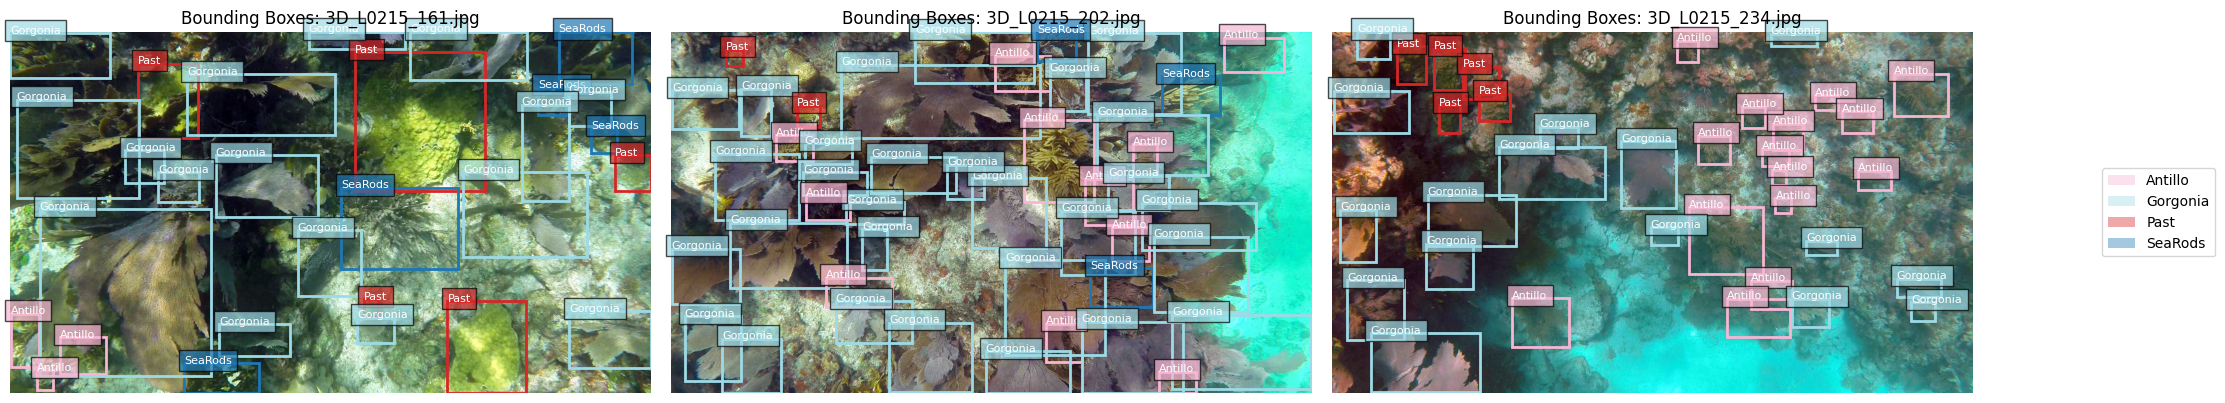


Drawing Polygon Annotations for:
0: 3D_L0215_161.jpg
1: 3D_L0215_202.jpg
2: 3D_L0215_234.jpg


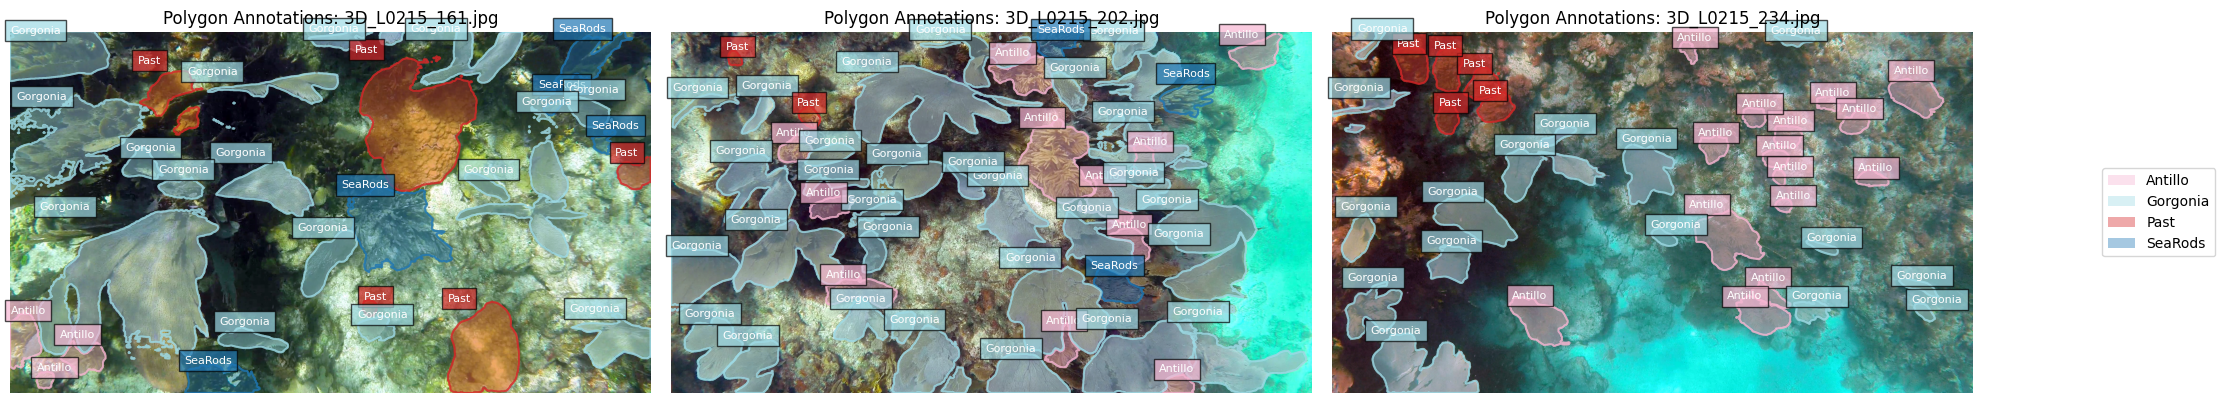

Original CSV shape: (3999, 6)
Generated CSV shape: (110, 4)

Unique categories in original: ['Past' 'Gorgonia' 'SeaRods' 'Antillo' 'Fish' 'Ssid' 'Orb' 'Other_Coral'
 'Apalm' 'Galaxaura']
Unique categories in generated: ['Past' 'Gorgonia' 'SeaRods' 'Antillo']

Annotations per image:
Original:
count    133.000000
mean      30.067669
std       12.326490
min        2.000000
25%       22.000000
50%       31.000000
75%       38.000000
max       56.000000
dtype: float64

Generated:
count     3.000000
mean     36.666667
std       8.020806
min      29.000000
25%      32.500000
50%      36.000000
75%      40.500000
max      45.000000
dtype: float64

Missing images: 130 of 133 (97.7%)
First 5 missing images: ['A_3D_L0646_48.jpg', 'B_3D_L0647_488.jpg', 'B_3D_L0647_290.jpg', 'B_3D_L0647_89.jpg', 'C_3D_L0648_301.jpg']

Extra images: 0


In [9]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

def visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    print("Drawing Bounding Boxes for:")
    for i, img in enumerate(annotations['images'][:num_images]):
        print(f"{i}: {img['file_name']}")

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]

    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = axes[idx]
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            bbox = ann['bbox']
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                           fill=False, color=color, linewidth=2)
            ax.add_patch(rect)

            ax.text(bbox[0], bbox[1], label,
                   color='white', fontsize=8,
                   bbox=dict(facecolor=color, alpha=0.7))

        ax.set_axis_off()
        ax.set_title(f"Bounding Boxes: {selected_image['file_name']}")

    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=category_colors[cat],
                               alpha=0.4, label=cat) for cat in sorted(all_categories)]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

def visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)

    with open(label_mapping_file) as f:
        label_map = json.load(f)

    if len(annotations['images']) == 0:
        print("No images found in annotations file")
        return

    print("\nDrawing Polygon Annotations for:")
    for i, img in enumerate(annotations['images'][:num_images]):
        print(f"{i}: {img['file_name']}")

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]

    colors = plt.colormaps['tab20'](np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = axes[idx]
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            for segment in ann['segmentation']:
                poly = np.array(segment).reshape(-1, 2)
                ax.fill(poly[:, 0], poly[:, 1], alpha=0.4, color=color)
                ax.plot(poly[:, 0], poly[:, 1], color=color, alpha=0.7)

            bbox = ann['bbox']
            ax.text(bbox[0], bbox[1], label,
                   color='white', fontsize=8,
                   bbox=dict(facecolor=color, alpha=0.7))

        ax.set_axis_off()
        ax.set_title(f"Polygon Annotations: {selected_image['file_name']}")

    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=category_colors[cat],
                               alpha=0.4, label=cat) for cat in sorted(all_categories)]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

def compare_csv_files(original_csv, generated_csv):
    if not os.path.exists(original_csv):
        print(f"Original CSV file not found: {original_csv}")
        return
    if not os.path.exists(generated_csv):
        print(f"Generated CSV file not found: {generated_csv}")
        return

    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    print("Original CSV shape:", df_original.shape)
    print("Generated CSV shape:", df_generated.shape)

    original_categories = df_original['label'].unique() if 'label' in df_original.columns else []
    generated_categories = df_generated['category'].unique() if 'category' in df_generated.columns else []

    print("\nUnique categories in original:", original_categories)
    print("Unique categories in generated:", generated_categories)

    print("\nAnnotations per image:")
    print("Original:")
    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    orig_stats = df_original.groupby(image_col_orig).size().describe()
    print(orig_stats)

    print("\nGenerated:")
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'
    gen_stats = df_generated.groupby(image_col_gen).size().describe()
    print(gen_stats)

    original_images = set(df_original[image_col_orig])
    generated_images = set(df_generated[image_col_gen])

    missing_images = original_images - generated_images
    extra_images = generated_images - original_images

    print(f"\nMissing images: {len(missing_images)} of {len(original_images)} ({len(missing_images)/len(original_images)*100:.1f}%)")
    if len(missing_images) > 0:
        print("First 5 missing images:", list(missing_images)[:5])

    print(f"\nExtra images: {len(extra_images)}")
    if len(extra_images) > 0:
        print("Extra images:", list(extra_images))

image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
annotations_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.json"
label_mapping_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/label_mapping.json"

visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3)
visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3)

original_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
generated_csv = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.csv"
compare_csv_files(original_csv, generated_csv)

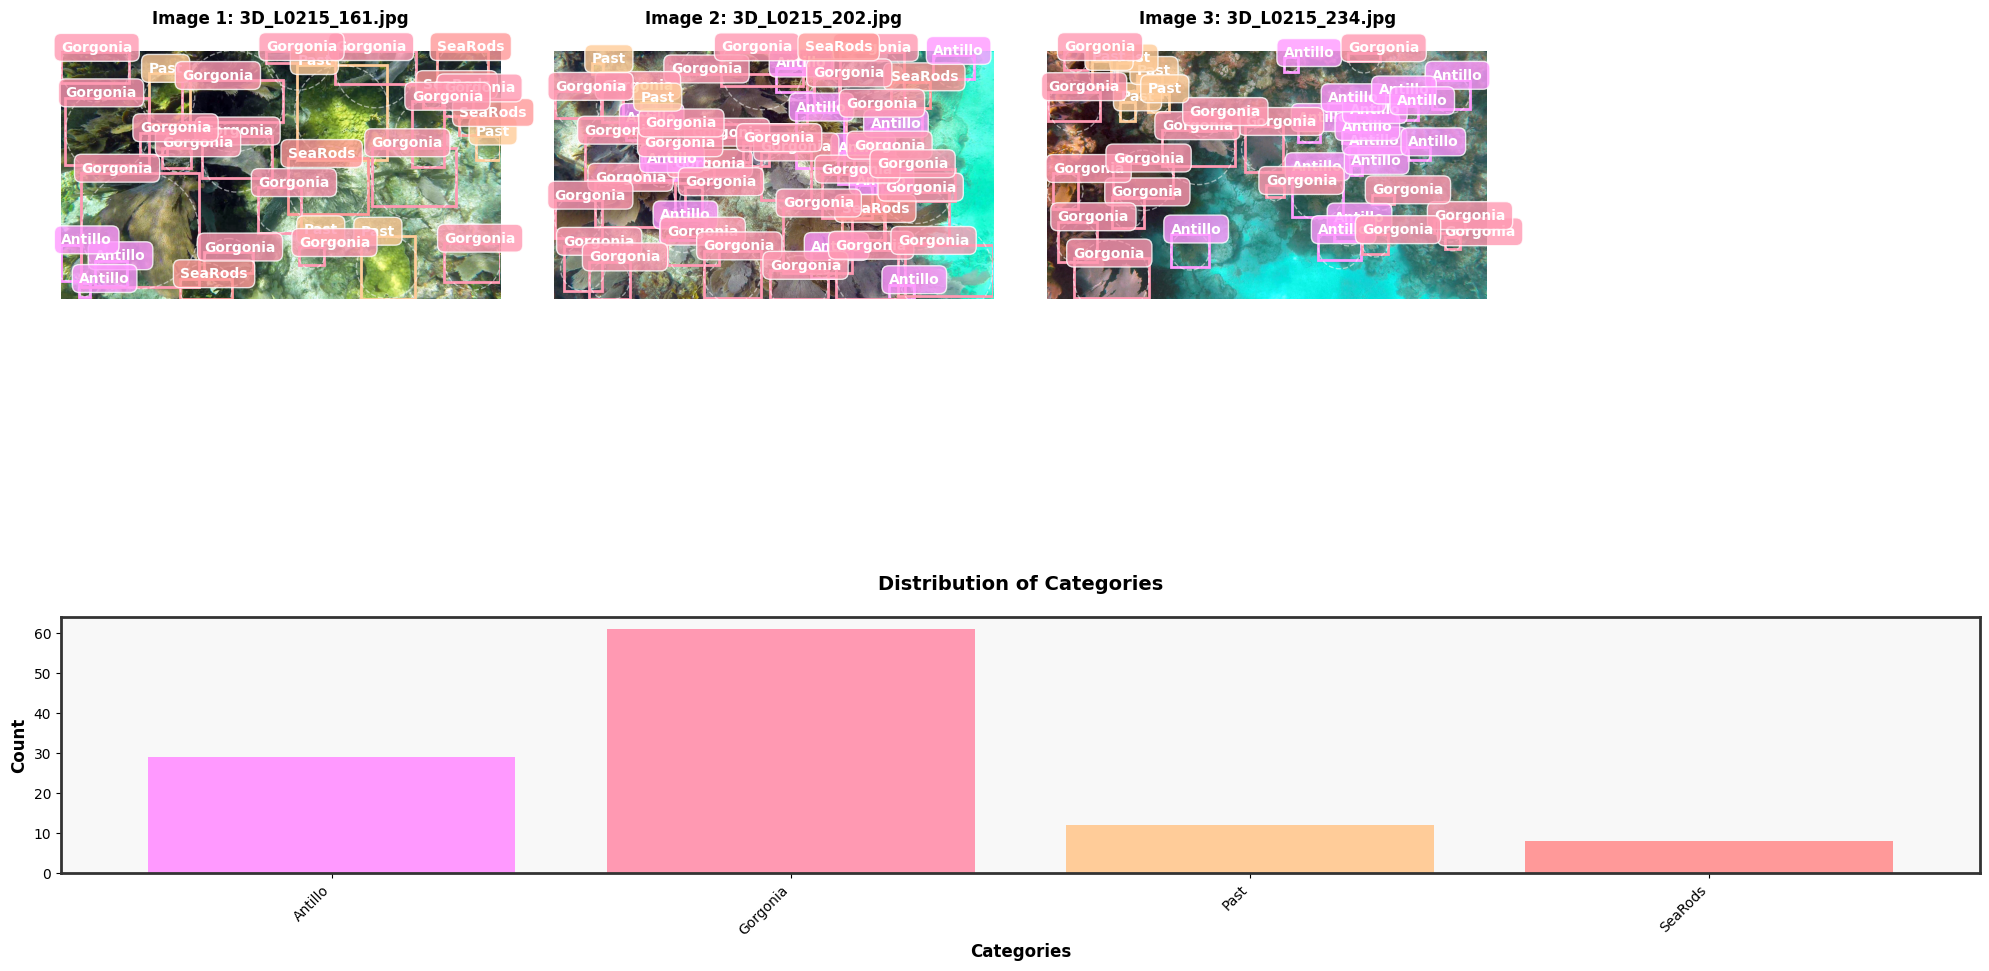

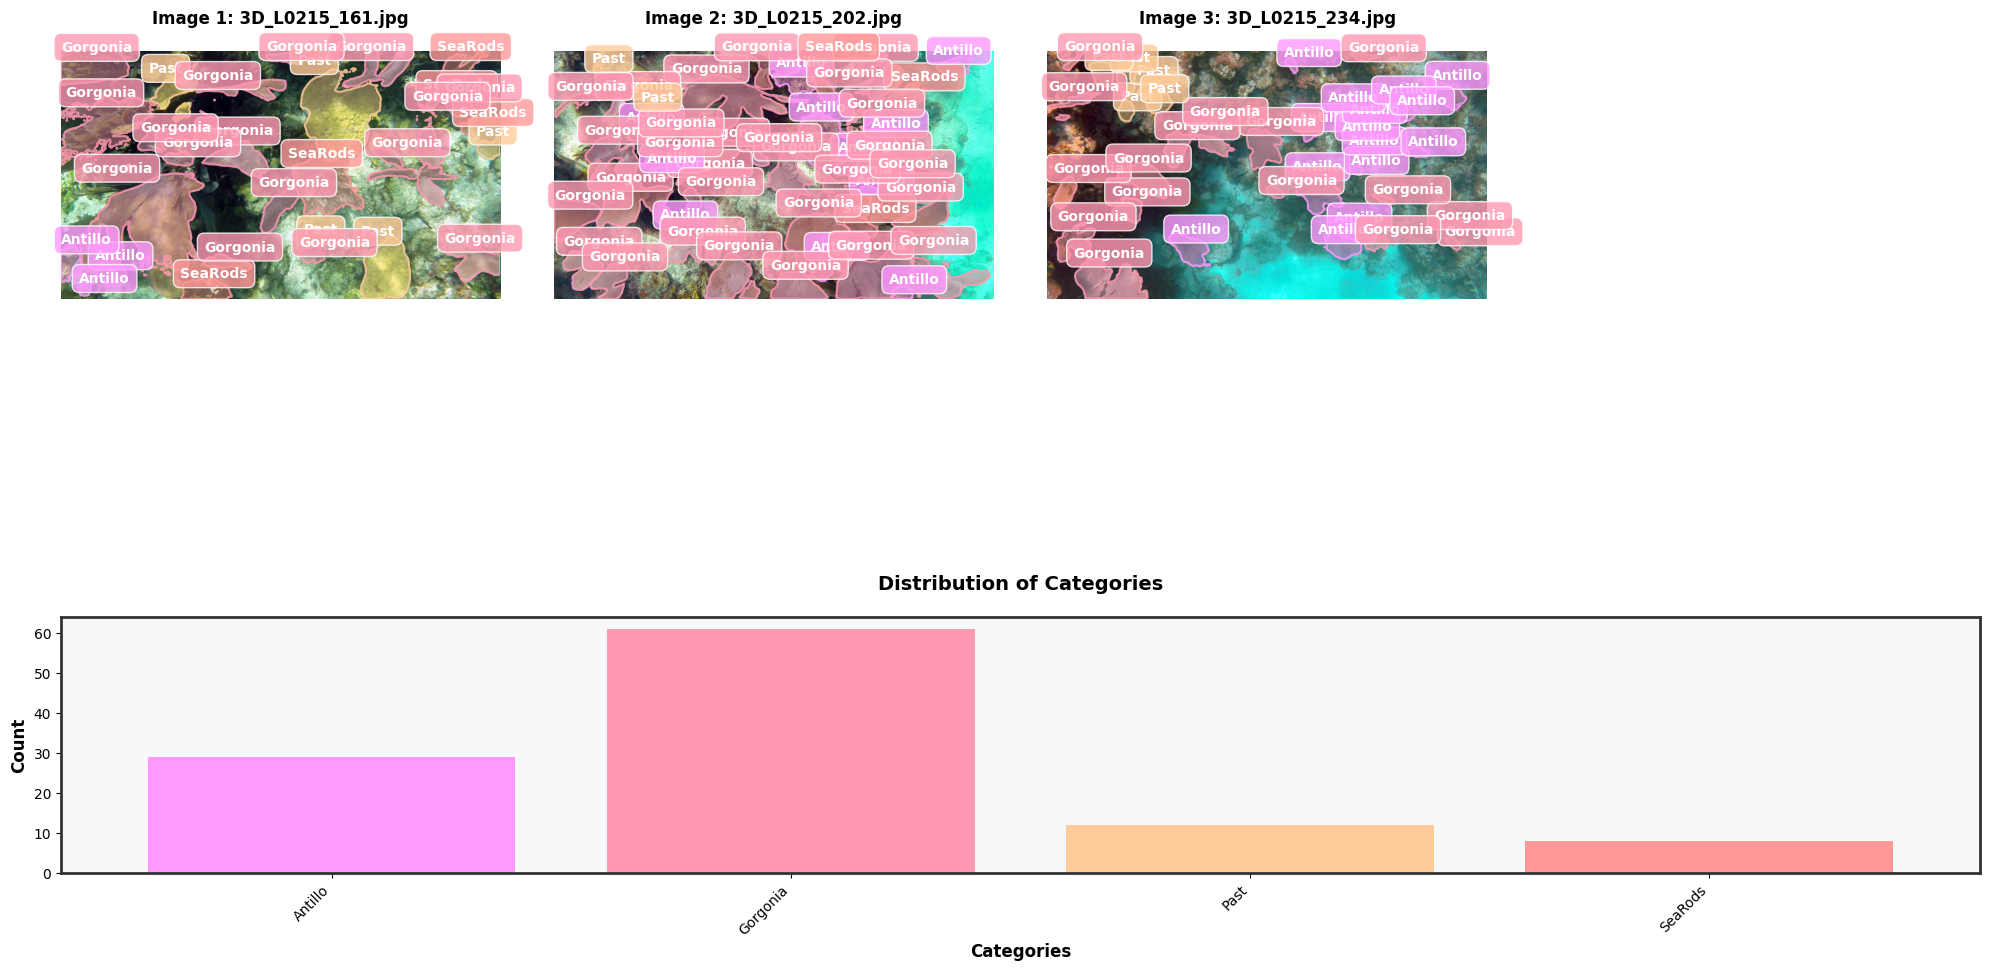

In [13]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Polygon, Circle
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_custom_colormap():
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC',
              '#99FFCC', '#FF99FF', '#FFB366', '#99FF99', '#FF99B2']
    return LinearSegmentedColormap.from_list('custom', colors, N=256)

def add_fancy_borders(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('#333333')
    ax.set_facecolor('#F8F8F8')

def create_circular_mask(ax, bbox):
    center = (bbox[0] + bbox[2]/2, bbox[1] + bbox[3]/2)
    radius = max(bbox[2], bbox[3]) / 2
    circle = Circle(center, radius, fill=False, linestyle='--', color='white', alpha=0.5)
    ax.add_patch(circle)

def enhanced_visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)
    with open(label_mapping_file) as f:
        label_map = json.load(f)

    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, num_images + 1, height_ratios=[3, 1])

    custom_cmap = create_custom_colormap()
    colors = custom_cmap(np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = plt.subplot(gs[0, idx])
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations']
                           if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            bbox = ann['bbox']
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                           fill=False, color=color, linewidth=2)
            ax.add_patch(rect)
            create_circular_mask(ax, bbox)

            ax.text(bbox[0], bbox[1] - 5, label,
                   color='white', fontsize=10, fontweight='bold',
                   bbox=dict(facecolor=color, alpha=0.8, pad=2,
                           edgecolor='white', boxstyle='round,pad=0.5'))

        add_fancy_borders(ax)
        ax.set_axis_off()
        ax.set_title(f"Image {idx + 1}: {selected_image['file_name']}",
                    pad=20, fontsize=12, fontweight='bold')

    ax_stats = plt.subplot(gs[1, :])
    categories = sorted(all_categories)
    category_counts = {cat: 0 for cat in categories}

    for ann in annotations['annotations']:
        category_counts[ann['category_name']] += 1

    bars = ax_stats.bar(categories, [category_counts[cat] for cat in categories],
                       color=[category_colors[cat] for cat in categories])

    ax_stats.set_xlabel('Categories', fontsize=12, fontweight='bold')
    ax_stats.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax_stats.set_title('Distribution of Categories', pad=20,
                      fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    add_fancy_borders(ax_stats)

    plt.tight_layout()
    return fig

def enhanced_visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3):
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found: {annotations_file}")
        return
    if not os.path.exists(label_mapping_file):
        print(f"Label mapping file not found: {label_mapping_file}")
        return
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return

    with open(annotations_file) as f:
        annotations = json.load(f)
    with open(label_mapping_file) as f:
        label_map = json.load(f)

    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, num_images + 1, height_ratios=[3, 1])

    custom_cmap = create_custom_colormap()
    colors = custom_cmap(np.linspace(0, 1, len(label_map)))
    all_categories = set()
    category_colors = {}

    for idx in range(min(num_images, len(annotations['images']))):
        ax = plt.subplot(gs[0, idx])
        selected_image = annotations['images'][idx]
        image_path = os.path.join(image_dir, selected_image['file_name'])

        image = cv2.imread(image_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)

        image_id = selected_image['id']
        image_annotations = [ann for ann in annotations['annotations']
                           if ann['image_id'] == image_id]

        for ann in image_annotations:
            color = colors[ann['category_id']][:3]
            label = ann['category_name']
            category_colors[label] = color
            all_categories.add(label)

            for segment in ann['segmentation']:
                poly = np.array(segment).reshape(-1, 2)
                ax.fill(poly[:, 0], poly[:, 1], alpha=0.4, color=color)
                ax.plot(poly[:, 0], poly[:, 1], color=color, alpha=0.7)

            bbox = ann['bbox']
            ax.text(bbox[0], bbox[1] - 5, label,
                   color='white', fontsize=10, fontweight='bold',
                   bbox=dict(facecolor=color, alpha=0.8, pad=2,
                           edgecolor='white', boxstyle='round,pad=0.5'))

        add_fancy_borders(ax)
        ax.set_axis_off()
        ax.set_title(f"Image {idx + 1}: {selected_image['file_name']}",
                    pad=20, fontsize=12, fontweight='bold')

    ax_stats = plt.subplot(gs[1, :])
    categories = sorted(all_categories)
    category_counts = {cat: 0 for cat in categories}

    for ann in annotations['annotations']:
        category_counts[ann['category_name']] += 1

    bars = ax_stats.bar(categories, [category_counts[cat] for cat in categories],
                       color=[category_colors[cat] for cat in categories])

    ax_stats.set_xlabel('Categories', fontsize=12, fontweight='bold')
    ax_stats.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax_stats.set_title('Distribution of Categories', pad=20,
                      fontsize=14, fontweight='bold')

    plt.xticks(rotation=45, ha='right')
    add_fancy_borders(ax_stats)

    plt.tight_layout()
    return fig

def enhanced_compare_csv_files(original_csv, generated_csv):
    if not os.path.exists(original_csv) or not os.path.exists(generated_csv):
        return

    df_original = pd.read_csv(original_csv)
    df_generated = pd.read_csv(generated_csv)

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Category Distribution - Original',
                       'Category Distribution - Generated',
                       'Annotations per Image',
                       'Image Comparison'),
        specs=[[{"type": "bar"}, {"type": "bar"}],
               [{"type": "box"}, {"type": "pie"}]]
    )

    orig_cats = df_original['label'].value_counts()
    gen_cats = df_generated['category'].value_counts()

    fig.add_trace(
        go.Bar(x=orig_cats.index, y=orig_cats.values,
               name='Original', marker_color='#2ecc71'),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(x=gen_cats.index, y=gen_cats.values,
               name='Generated', marker_color='#3498db'),
        row=1, col=2
    )

    image_col_orig = 'image' if 'image' in df_original.columns else 'image_name'
    image_col_gen = 'image_name' if 'image_name' in df_generated.columns else 'image'

    orig_counts = df_original.groupby(image_col_orig).size()
    gen_counts = df_generated.groupby(image_col_gen).size()

    fig.add_trace(
        go.Box(y=orig_counts.values, name='Original',
               marker_color='#2ecc71', boxpoints='outliers'),
        row=2, col=1
    )
    fig.add_trace(
        go.Box(y=gen_counts.values, name='Generated',
               marker_color='#3498db', boxpoints='outliers'),
        row=2, col=1
    )

    original_images = set(df_original[image_col_orig])
    generated_images = set(df_generated[image_col_gen])

    common_images = len(original_images & generated_images)
    missing_images = len(original_images - generated_images)
    extra_images = len(generated_images - original_images)

    fig.add_trace(
        go.Pie(labels=['Common', 'Missing', 'Extra'],
               values=[common_images, missing_images, extra_images],
               marker_colors=['#2ecc71', '#e74c3c', '#f1c40f']),
        row=2, col=2
    )

    fig.update_layout(
        height=1000,
        width=1400,
        showlegend=True,
        title_text="Detailed Dataset Comparison Analysis",
        title_x=0.5,
        title_font_size=24,
        paper_bgcolor='white',
        plot_bgcolor='rgba(240,240,240,0.95)',
        legend=dict(
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=1
        ),
        font=dict(family="Arial, sans-serif", size=12)
    )

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     showline=True, linewidth=1, linecolor='rgba(0,0,0,0.3)')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     showline=True, linewidth=1, linecolor='rgba(0,0,0,0.3)')

    fig.update_traces(marker_line_color='rgb(8,48,107)',
                     marker_line_width=1.5, opacity=0.8)

    return fig

def create_statistical_dashboard(df_original, df_generated):
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Annotations per Category',
                       'Distribution of Annotations',
                       'Timeline of Annotations',
                       'Category Correlation'),
        specs=[[{"type": "bar"}, {"type": "histogram"}],
               [{"type": "scatter"}, {"type": "heatmap"}]]
    )
    return fig

# Usage
image_dir = "/content/drive/MyDrive/Coral-Reef-Research/Datasetsenhanced-20241028T214944Z-001enhanced"
annotations_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.json"
label_mapping_file = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/label_mapping.json"

original_csv = "/content/drive/MyDrive/Coral-Reef-Research/FL_Keys_Coral-export.csv"
generated_csv = "/content/drive/MyDrive/Coral-Reef-Research/segmentation_results/annotations_with_labels.csv"

fig_boxes = enhanced_visualize_bounding_boxes(image_dir, annotations_file, label_mapping_file, num_images=3)
plt.show()

fig_polygons = enhanced_visualize_polygons(image_dir, annotations_file, label_mapping_file, num_images=3)
plt.show()

try:
    fig_comparison = enhanced_compare_csv_files(original_csv, generated_csv)
    fig_comparison.show()
except Exception as e:
    print(f"Error creating comparison visualization: {str(e)}")